In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn import preprocessing

In [2]:
data = pd.read_csv('processed_data.csv')
data.head(3)

,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Berri1,Maisonneuve_2,Maisonneuve_1
0,2009.0,1.0,1.0,-14.7,-19.9,-17.3,-23.125000,59.916667,28.291667,17.375000,29.0,35.0,20.0
1,2009.0,1.0,2.0,-11.3,-16.2,-13.8,-17.029167,76.250000,7.083333,12.250000,19.0,22.0,3.0
2,2009.0,1.0,3.0,-8.1,-13.0,-10.6,-15.441667,67.958333,28.208333,22.541667,24.0,22.0,12.0


In [3]:
X = torch.Tensor(data.drop(columns=['Berri1','Maisonneuve_2','Maisonneuve_1']).to_numpy())
X = X[:, 3:]
rnd_idx = torch.randperm(X.shape[0])
X = X[rnd_idx]
y = torch.Tensor(data['Berri1'].to_numpy()).unsqueeze(1)
y = y[rnd_idx]

Let's use standard scaler on the input features to remove any biases or large numbers.

In [4]:
scaler_X = preprocessing.StandardScaler()
scaler_y = preprocessing.StandardScaler()
X = torch.Tensor(scaler_X.fit_transform(X))
y = torch.Tensor(scaler_y.fit_transform(y))

Let's Split the test and train datasets

In [5]:
split = 0.08 # 8% train/test split

X_train = X[:int(X.shape[0]*(1-split))]
X_test = X[int(X.shape[0]*(1-split)):]

y_train = y[:int(X.shape[0]*(1-split))]
y_test = y[int(X.shape[0]*(1-split)):]
print("X:", X.shape, "y:", y.shape,
      "\nX_trn:", X_train.shape, "y_trn:", y_train.shape,
      "\nX_tst:", X_test.shape, "y_tst:", y_test.shape)


X: torch.Size([2743, 7]) y: torch.Size([2743, 1]) 
X_trn: torch.Size([2523, 7]) y_trn: torch.Size([2523, 1]) 
X_tst: torch.Size([220, 7]) y_tst: torch.Size([220, 1])


For this first model we will simply feed the data and solve a regression task.

In [6]:
class BikeModel(torch.nn.Module):
    def __init__(self,batch_first=True):
        super(BikeModel, self).__init__()
        self.linear1 = torch.nn.Linear(in_features=7, out_features=10)
        self.linear2 = torch.nn.Linear(in_features=10,out_features=10)
        self.linear3 = torch.nn.Linear(in_features=10,out_features=1)
        self.drop1 = torch.nn.Dropout(p=0.5)
        self.drop2 = torch.nn.Dropout(p=0.5)
    def forward(self, X):
        #print(X.shape)
        H = self.linear1(X)
        H = self.drop1(torch.nn.functional.relu(H))
        
        #print(H.shape)
        Z = self.linear2(H)
        H = self.drop2(torch.nn.functional.relu(Z))
        #print(Z.shape)
        Z = self.linear3(Z)
        H = torch.nn.functional.relu(Z)
        #print(Z.shape)
        return Z

In [7]:
# Hyperparameters
lr = 0.01
batch_size = 1000
num_epoch = 2000

# Initialize the model 
ann = BikeModel()

# Initialize the Loss. 
loss = torch.nn.MSELoss()
train_loss = []
test_loss = []
# Initialize the Optimizer.
optimizer = torch.optim.Adam(ann.parameters(),lr=lr)

# Training Loop
for epoch in range(num_epoch):
    for i in range(0, X_train.shape[0], batch_size):

        # Read minibatches (for both X and y)
        Xi = X_train[i:i+batch_size]
        yi = y_train[i:i+batch_size]

        # Run the RNN model
        output = ann.forward(Xi)

        #     print('output',output.shape,'yi',yi.shape)
        l = loss(output,yi)

        # Update the parameters (zero_grad, backward, optimization step)
        ann.zero_grad()
        l.backward()
        optimizer.step()
        
    train_loss.append(l.item())
    ann.eval()
    output = ann.forward(X_test)
    l_test = loss(output, y_test)
    test_loss.append(l_test.item())
    # Print loss
    if (epoch + 1) % 200 == 0:
        print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))
        print("Epoch %03d: Test_loss: %.4f " %(epoch+1, l_test))

Epoch 200: Train_loss: 0.1758 
Epoch 200: Test_loss: 0.2653 
Epoch 400: Train_loss: 0.1740 
Epoch 400: Test_loss: 0.2666 
Epoch 600: Train_loss: 0.1735 
Epoch 600: Test_loss: 0.2665 
Epoch 800: Train_loss: 0.1731 
Epoch 800: Test_loss: 0.2662 
Epoch 1000: Train_loss: 0.1729 
Epoch 1000: Test_loss: 0.2663 
Epoch 1200: Train_loss: 0.1724 
Epoch 1200: Test_loss: 0.2665 
Epoch 1400: Train_loss: 0.1723 
Epoch 1400: Test_loss: 0.2665 
Epoch 1600: Train_loss: 0.1724 
Epoch 1600: Test_loss: 0.2663 
Epoch 1800: Train_loss: 0.1723 
Epoch 1800: Test_loss: 0.2663 
Epoch 2000: Train_loss: 0.1723 
Epoch 2000: Test_loss: 0.2663 


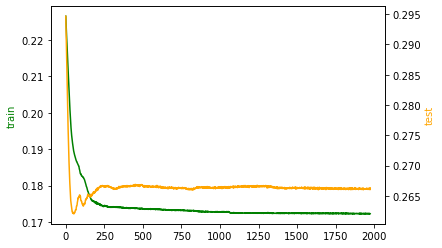

In [8]:
import matplotlib.pyplot as plt
ax = plt.subplot((111))
plt.plot(train_loss[25:], 'green')
plt.ylabel('train', c='green')
ax2= ax.twinx()
plt.plot(test_loss[25:], 'orange')
plt.ylabel('test', c='orange');

Train Data performance

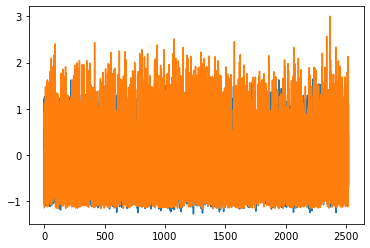

In [9]:

ann.eval()
plt.plot(ann.forward(X_train).detach().squeeze())
plt.plot(y_train.squeeze())

Test data performance

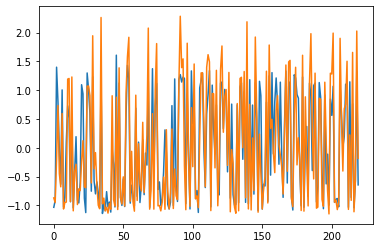

In [10]:
import matplotlib.pyplot as plt
plt.plot(ann.forward(X_test).detach().squeeze())
plt.plot(y_test.squeeze())

In [17]:
from sklearn.metrics import accuracy_score
#bins = [0, 100, 500, 1000, 2000, 4000, 8000, 1000000]
bins = np.linspace(0,10_000,100)

x_out_train = scaler_y.inverse_transform(ann.forward(X_train).detach().numpy())
y_out_train = scaler_y.inverse_transform(y_train.numpy())

bin_x_train = np.digitize(x_out_train, bins)
bin_y_train = np.digitize(y_out_train, bins)

x_out_test = scaler_y.inverse_transform(ann.forward(X_test).detach().numpy())
y_out_test = scaler_y.inverse_transform(y_test.numpy())

bin_x_test = np.digitize(x_out_test, bins)
bin_y_test = np.digitize(y_out_test, bins)


print("Training accuracy: {:.2f}%".format( accuracy_score(bin_x_train,bin_y_train)*100) )
print("Testing accuracy: {:.2f}%".format( accuracy_score(bin_x_test,bin_y_test)*100) )

Training accuracy: 6.94%
Testing accuracy: 7.73%


We can verify that the propper bins were in fact by printing the first few values

In [12]:
x_out,y_out,bin_x_train[0:10], bin_y_train[0:10]

NameError: name 'x_out' is not defined